In [1]:
import logging
import os

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro

from utils import *

/users/qingjian/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pkts = np.zeros([0, 3])

for i in [1]:
    filename = "../data/YouTube_Live/YouTube_Live_{}.csv".format(i)

    df = load_csv(filename)
    
    # data = extract_dl_pkt_interval_time(df, target_ip)
    data = extract_pkt_interval_time(df)
    pkts = np.concatenate((pkts, data), axis=0)
    print(pkts.shape)

(914412, 3)


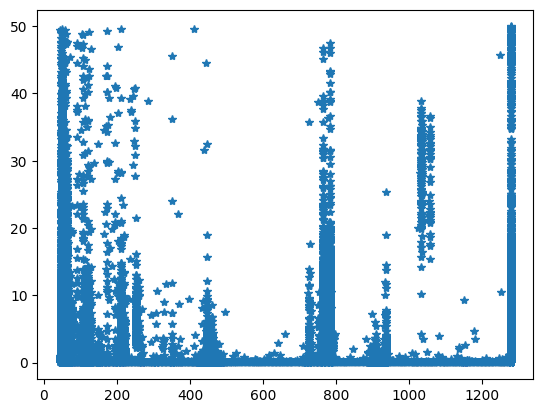

In [3]:
pkt_interval = pkts[pkts[:, 0] < 0.05, :]

pkt_interval[:, 0] = pkt_interval[:, 0] * 1000

count, bins_count = np.histogram(pkt_interval[:, 0], bins=1000) 
pdf = count / sum(count) 
cdf = np.cumsum(pdf) 

plt.figure()
plt.plot(pkt_interval[:, 2], pkt_interval[:, 0], '*')

Text(0.5, 1.0, 'Downlink pkt inter-arrival time')

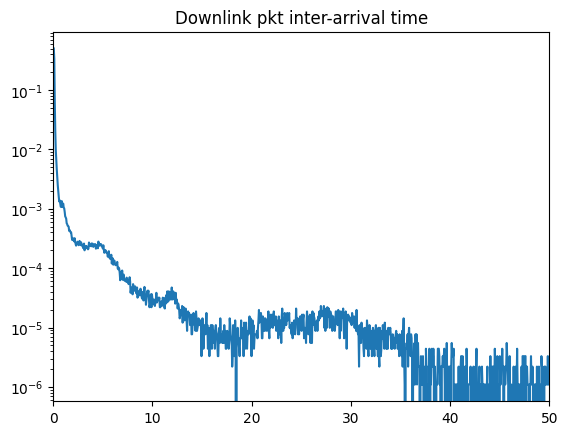

In [4]:
plt.figure()
plt.plot(bins_count[1:], pdf)
plt.xlim([0, 50])
plt.yscale("log")
plt.title("Downlink pkt inter-arrival time")

In [5]:
train = torch.tensor(pkt_interval, dtype=torch.float)
pkt_interval, time, pkt_size = train[:, 0], train[:, 1], train[:, 2]

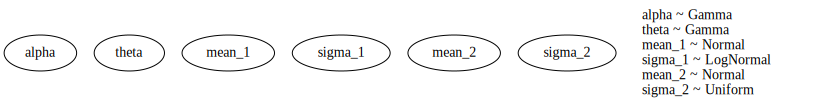

In [7]:
import pyro.distributions as dist
import pyro.distributions.constraints as constraints

# def categorical_possion()

def model(pkt_size, pkt_interval=None):
    alpha = pyro.sample("alpha", dist.Gamma(1., 1.))
    theta = pyro.sample("theta", dist.Gamma(1., 1.))
    gamma = dist.Gamma(alpha, theta)

    mean_1 = pyro.sample("mean_1", dist.Normal(5, 2))
    sigma_1 = pyro.sample("sigma_1", dist.LogNormal(0., 0.05))
    gaussian_1 = dist.Normal(mean_1, sigma_1)

    mean_2 = pyro.sample("mean_2", dist.Normal(12, 2))
    sigma_2 = pyro.sample("sigma_2", dist.Uniform(0., 0.05))
    gaussian_2 = dist.Normal(mean_2, sigma_2)

    cat_dist = dist.OneHotCategorical(torch.Tensor([0.7, 0.2, 0.1]))
    y = cat_dist.sample()

    gamma_samp = gamma.sample()
    gaussian_samp_1 = gaussian_1.sample()
    gaussian_samp_2 = gaussian_2.sample()
    
    with pyro.plate("data", len(time)):
        return y[0] * gamma_samp + y[1] * gaussian_samp_1 + y[2] * gaussian_samp_2

pyro.render_model(model, model_args=(pkt_size, pkt_interval), render_distributions=True)

In [9]:
def custom_guide(pkt_size, pkt_interval=None):
    alpha_alpha = pyro.param('alpha_alpha', lambda: torch.tensor(1.),
                             constraint=constraints.positive)
    alpha_theta = pyro.param('alpha_theta', lambda: torch.tensor(1.),
                             constraint=constraints.positive)
    alpha = pyro.sample('alpha', dist.Gamma(alpha_alpha, alpha_theta))

    theta_alpha = pyro.param('theta_alpha', lambda: torch.tensor(1.),
                             constraint=constraints.positive)
    theta_theta = pyro.param('theta_theta', lambda: torch.tensor(1.),
                             constraint=constraints.positive)
    theta = pyro.sample('theta', dist.Gamma(theta_alpha, theta_theta))

    mean_1_loc = pyro.param('mean_1_loc', lambda: torch.tensor(5. ))
    sigma_1_loc = pyro.param('sigma_1_loc', lambda: torch.tensor(0.))
    mean_1 = pyro.sample('mean_1', dist.Normal(mean_1_loc, torch.tensor(0.05)))
    sigma_1 = pyro.sample('sigma_1', dist.LogNormal(sigma_1_loc, torch.tensor(0.005)))

    mean_2_loc = pyro.param('mean_2_loc', lambda: torch.tensor(12. ))
    sigma_2_loc = pyro.param('sigma_2_loc', lambda: torch.tensor(0.))
    mean_2 = pyro.sample('mean_2', dist.Normal(mean_2_loc, torch.tensor(0.05)))
    sigma_2 = pyro.sample('sigma_2', dist.LogNormal(sigma_2_loc, torch.tensor(0.005)))

    # weight_1 = pyro.param('weight_1', lambda: torch.tensor(0.9),
    #                       constraint=constraints.positive)
    # weight_2 = pyro.param('weight_2', lambda: torch.tensor(0.05),
    #                       constraint=constraints.positive)
    # weight_3 = pyro.param('weight_3', lambda: torch.tensor(0.05),
    #                       constraint=constraints.positive)
    # cat = dist.OneHotCategorical(torch.Tensor([weight_1, weight_2, weight_3]))
    # y = pyro.sample('y', cat)

    return {'alpha': alpha, 'theta': theta, 'mean_1': mean_1, 'sigma_1': sigma_1, 
            'mean_2': mean_2, 'sigma_2': sigma_2}

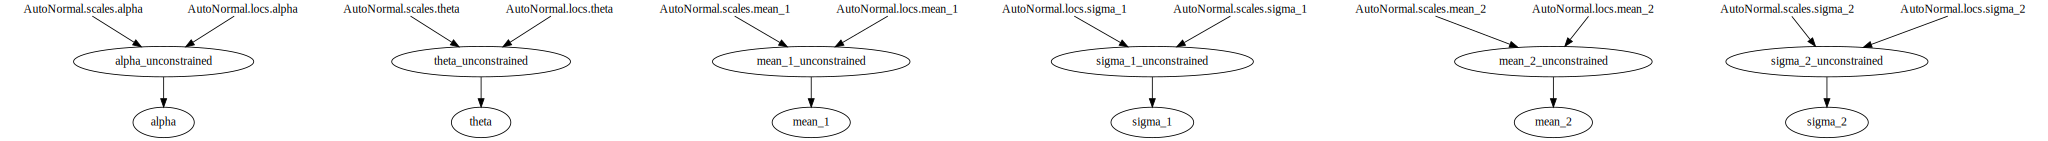

In [10]:
auto_guide = pyro.infer.autoguide.AutoNormal(model)

pyro.render_model(auto_guide, model_args=(pkt_size, pkt_interval), render_params=True)

Step: 0, Elbo loss: 40.15337630547583
Step: 100, Elbo loss: 17.490439295768738
Step: 200, Elbo loss: 12.39946560561657
Step: 300, Elbo loss: 9.08975875005126
Step: 400, Elbo loss: 2.6704013124108315
Step: 500, Elbo loss: 2.2091465331614017
Step: 600, Elbo loss: 1.218878984451294
Step: 700, Elbo loss: 5.121982350945473
Step: 800, Elbo loss: 1.1212953142821789
Step: 900, Elbo loss: -0.49670759588479996
Step: 1000, Elbo loss: 0.7844623941928148
Step: 1100, Elbo loss: 0.864324577152729
Step: 1200, Elbo loss: 0.7672238275408745
Step: 1300, Elbo loss: -0.006625354755669832
Step: 1400, Elbo loss: 1.0732305170968175
Step: 1500, Elbo loss: 0.32255543768405914
Step: 1600, Elbo loss: 0.06875226646661758
Step: 1700, Elbo loss: 0.0671074390411377
Step: 1800, Elbo loss: -0.25898874644190073
Step: 1900, Elbo loss: 1.748824067413807
Step: 2000, Elbo loss: 0.23551392555236816
Step: 2100, Elbo loss: -0.061398427933454514
Step: 2200, Elbo loss: 7.058407083153725
Step: 2300, Elbo loss: -0.1130956560373306

Text(0, 0.5, 'ELBO loss')

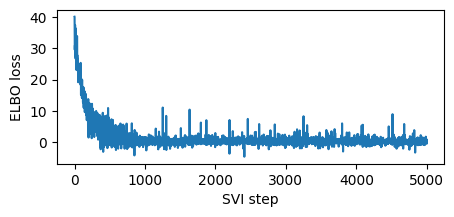

In [11]:
adam = pyro.optim.Adam({"lr": 0.02})
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model, auto_guide, adam, elbo)

smoke_test = ('CI' in os.environ)

pyro.clear_param_store()

# These should be reset each training loop.
adam = pyro.optim.Adam({"lr": 0.02})  # Consider decreasing learning rate.
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model, auto_guide, adam, elbo)

losses = []
for step in range(5000 if not smoke_test else 2):  # Consider running for more steps.
    loss = svi.step(pkt_size, pkt_interval)
    losses.append(loss)
    if step % 100 == 0:
        print("Step: {}, Elbo loss: {}".format(step, loss))

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss")

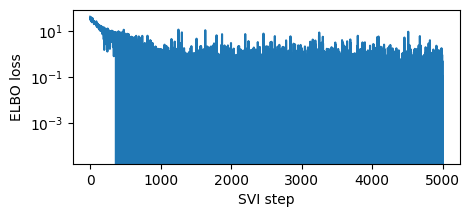

In [12]:
plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.yscale("log")
plt.xlabel("SVI step")
plt.ylabel("ELBO loss");

In [13]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).data.cpu().numpy())

AutoNormal.locs.alpha -0.43063584
AutoNormal.scales.alpha 0.9371811
AutoNormal.locs.theta -0.62975115
AutoNormal.scales.theta 0.93963504
AutoNormal.locs.mean_1 4.9746346
AutoNormal.scales.mean_1 2.0642056
AutoNormal.locs.sigma_1 0.024339108
AutoNormal.scales.sigma_1 0.055725712
AutoNormal.locs.mean_2 11.924694
AutoNormal.scales.mean_2 1.9664562
AutoNormal.locs.sigma_2 0.23095141
AutoNormal.scales.sigma_2 1.7864676


In [14]:
res = []
for i in range(10000):
  predictive = pyro.infer.Predictive(model, guide=auto_guide, num_samples=1)
  svi_samples = predictive(pkt_size, pkt_interval=None)

  gamma_samp = dist.Exponential(svi_samples['alpha'][0]).sample()
  gaussian_samp_1 = dist.Normal(svi_samples['mean_1'][0], svi_samples['sigma_1'][0]).sample()
  gaussian_samp_2 = dist.Normal(svi_samples['mean_2'][0], svi_samples['sigma_2'][0]).sample()
  cat_dist = dist.OneHotCategorical(torch.Tensor([0.9, 0.05, 0.05]))
  y = cat_dist.sample()
  res.append(y[0] * gamma_samp + y[1] * gaussian_samp_1 + y[2] * gaussian_samp_2)

print(res)

[tensor(0.0857), tensor(7.1338), tensor(0.2684), tensor(2.6102), tensor(1.0244), tensor(0.1555), tensor(0.1627), tensor(1.3457), tensor(6.2696), tensor(7.1250), tensor(0.8492), tensor(1.0319), tensor(1.3721), tensor(0.7754), tensor(2.5049), tensor(10.4789), tensor(0.7443), tensor(1.5139), tensor(1.3752), tensor(5.4194), tensor(0.1285), tensor(0.4562), tensor(1.9233), tensor(1.3883), tensor(26.1071), tensor(4.7426), tensor(0.6432), tensor(2.3571), tensor(0.1566), tensor(2.4092), tensor(0.8775), tensor(0.1911), tensor(0.3921), tensor(0.3173), tensor(2.1987), tensor(7.7699), tensor(6.9076), tensor(0.3430), tensor(2.3603), tensor(0.0229), tensor(1.8605), tensor(0.7717), tensor(4.2959), tensor(0.0264), tensor(0.5035), tensor(0.2249), tensor(0.0632), tensor(3.8940), tensor(2.3345), tensor(0.0779), tensor(3.3706), tensor(5.8559), tensor(3.9712), tensor(1.2361), tensor(2.6745), tensor(6.2971), tensor(0.0740), tensor(11.0574), tensor(2.2100), tensor(44.4116), tensor(9.1974), tensor(9.9712), ten

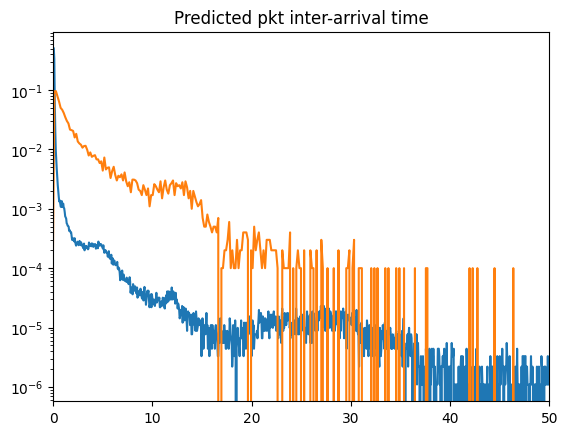

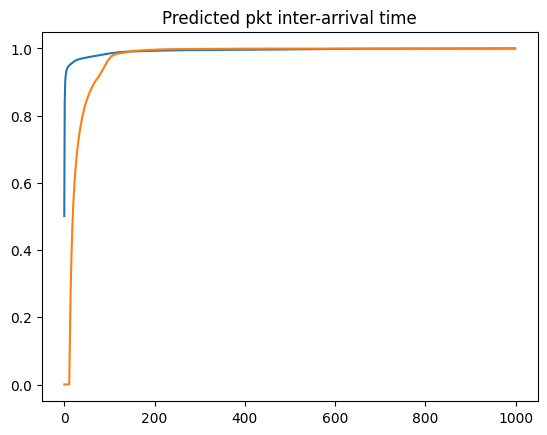

In [16]:
res = np.array(res)

res_count, res_bins_count = np.histogram(res, bins=1000) 
res_pdf = res_count / sum(res_count) 
res_cdf = np.cumsum(res_pdf) 

plt.figure()
plt.plot(bins_count[1:], pdf)
plt.yscale("log")
plt.title("Downlink pkt inter-arrival time")

# plt.figure()
plt.plot(res_bins_count[1:], res_pdf)
plt.xlim([0, 50])
plt.yscale("log")
plt.title("Predicted pkt inter-arrival time")

plt.figure()
plt.plot(cdf)
# plt.yscale("log")
plt.title("Downlink pkt inter-arrival time")

# plt.figure()
plt.plot(res_cdf)
# plt.yscale("log")
plt.title("Predicted pkt inter-arrival time")

plt.show()